# Transductive Methods

In this notebook, we will showcase how to use the Efficient Active Search (EAS) algorithm to find better solutions to existing problems!

> Tip: in [transductive RL](https://en.wikipedia.org/wiki/Transduction_(machine_learning)) we train (or finetune) to solve only specific ones.

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/modeling/2-transductive-methods.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

## Installation

Uncomment the following line to install the package from PyPI. Remember to choose a GPU runtime for faster training!

> Note: You may need to restart the runtime in Colab after this


In [ ]:
# !pip install rl4co[graph] # include torch-geometric

## NOTE: to install latest version from Github (may be unstable) install from source instead:
# !pip install git+https://github.com/ai4co/rl4co.git

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import TSPEnv, CVRPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.decoding import get_log_likelihood
from rl4co.models.zoo import EAS, EASLay, EASEmb, ActiveSearch

import logging

2023-08-22 16:29:17.903805: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 16:29:17.923169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 16:29:18.249479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load from checkpoint; alternatively, simply instantiate a new model
checkpoint_path = "last.ckpt" # model trained for one epoch only just for showing the examples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load checkpoint
# checkpoint = torch.load(checkpoint_path)

model = AttentionModel.load_from_checkpoint(checkpoint_path, load_baseline=False)
policy = model.policy.to(device)

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:164: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.model.encoder.init_embedding.init_embed.weight', 'baseline.baseline.model.encoder.init_embedding.init_embed.bias', 'baseline.baseline.model.encoder.net.layers.0.0.module.

In [3]:
# env = CVRPEnv(generator_params=dict(num_loc=50))
# policy = AttentionModel(env).policy.to(device)

env = TSPEnv(generator_params=dict(num_loc=50))

td = env.reset(batch_size=3).to(device)

out = policy(td)

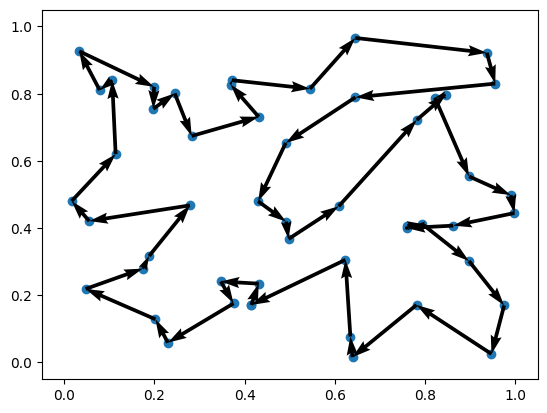

In [4]:
env.render(td.cpu(), out["actions"].cpu())

## EAS

We perform few iterations of EASLay for demonstration

In [5]:
logging.basicConfig(level=logging.DEBUG)

env.generator.num_loc = 200

dataset = env.dataset(batch_size=[2])
# eas_model = EASEmb(env, policy, dataset, batch_size=2, max_iters=20, save_path="eas_sols.pt") # alternative
eas_model = EASLay(env, policy, dataset, batch_size=2, max_iters=20, save_path="eas_sols.pt")

eas_model.setup()

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
  rank_zero_warn(
INFO:rl4co.models.rl.common.base:No metrics specified, using default
INFO:rl4co.models.zoo.eas.search:Setting up Efficient Active Search (EAS) with: 
- EAS Embedding: False 
- EAS Layer: True 



INFO:rl4co.models.common.constructive.autoregressive.policy:Instantiated environment not provided; instantiating tsp


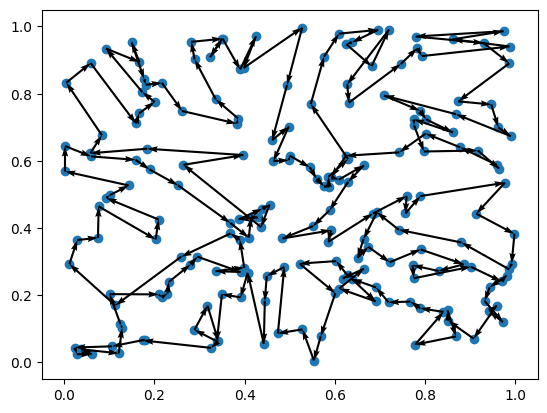

In [6]:
# Plot initial solution
td_dataset = next(iter(eas_model.train_dataloader()))
td_dataset = env.reset(td_dataset).to(device)
out = policy(td_dataset)

env.render(td_dataset.cpu(), out["actions"].cpu())

## Perform search 


In [7]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=1,
    gradient_clip_val=None,
)

trainer.fit(eas_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:rl4co.models.zoo.eas.search:Setting up Efficient Active Search (EAS) with: 
- EAS Embedding: False 
- EAS Layer: True 

DEBUG:fsspec.local:open file: /home/botu/Dev/rl4co-rebuttal/notebooks/dev/lightning_logs/version_181/hparams.yaml
DEBUG:fsspec.local:open file: /home/botu/Dev/rl4co-rebuttal/notebooks/dev/lightning_logs/version_181/hparams.yaml
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:rl4co.models.rl.common.base:Instantiating optimizer <Adam>

  | Name   | Type                 | Params
------------------------------------------------
0 | env    | TSPEnv               | 0     
1 | policy | AttentionModelPolicy | 710 K 
------------------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.841     Total estimated model para

Sanity Checking: 0it [00:00, ?it/s]

/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the

Training: 0it [00:00, ?it/s]

/home/botu/Dev/rl4co-rebuttal/notebooks/dev/../../rl4co/models/zoo/eas/nn.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.W1)
/home/botu/Dev/rl4co-rebuttal/notebooks/dev/../../rl4co/models/zoo/eas/nn.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.b1)
INFO:rl4co.models.rl.common.base:Instantiating optimizer <Adam>


/home/botu/miniconda3/envs/rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
INFO:rl4co.models.zoo.eas.search:0/20 |  Reward: -15.52 
INFO:rl4co.models.zoo.eas.search:1/20 |  Reward: -15.32 
INFO:rl4co.models.zoo.eas.search:2/20 |  Reward: -15.30 
INFO:rl4co.models.zoo.eas.search:3/20 |  Reward: -15.28 
INFO:rl4co.models.zoo.eas.search:4/20 |  Reward: -15.01 
INFO:rl4co.models.zoo.eas.search:5/20 |  Reward: -15.01 
INFO:rl4co.models.zoo.eas.search:6/20 |  Reward: -15.01 
INFO:rl4co.models.zoo.eas.search:7/20 |  Reward: -15.01 
INFO:rl4co.models.zoo.eas.search:8/20 |  Reward: -15.01 
INFO:rl4co.models.zoo.eas.search:9/20 |  Reward: -15.01 
INFO:rl4co.models.zoo.eas.search:10/20 |  Reward: -15.01 
INFO:rl4co.models.zoo.eas.search:11/20 |  Reward: -15.01 
INFO:rl4co.mode

Validation: 0it [00:00, ?it/s]

INFO:rl4co.models.zoo.eas.search:Saving solutions and rewards to eas_sols.pt...
`Trainer.fit` stopped: `max_epochs=1` reached.


## Load actions


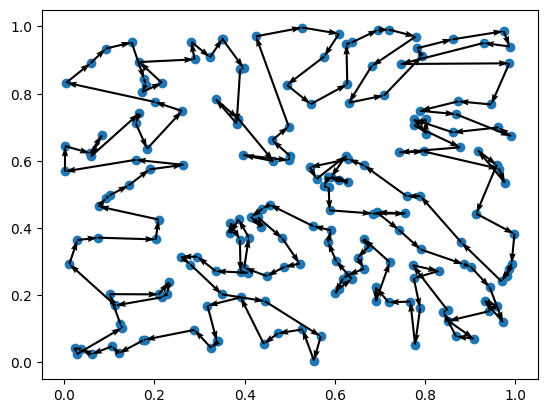

In [10]:
# Load
actions = torch.load("eas_sols.pt")["solutions"][0].cpu()
actions = actions[:torch.count_nonzero(actions, dim=-1)] # remove trailing zeros
state = td_dataset.cpu()[0]

env.render(state, actions)

Even with few iterations, the search method can clearly find better solutions than the initial ones!